In [1]:
import pandas as pd

df = pd.read_sas(r'C:\Users\459354\Desktop\Python\rsl_cust_list_adj_31oct2022.sas7bdat', encoding='iso-8859-1')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [247]:
# '~' means not in

def filter_condition(BUSINESS_UNIT,SUB_PRODUCT_CD): 
    if BUSINESS_UNIT == 'TREASURY' and (SUB_PRODUCT_CD =='AFS' or SUB_PRODUCT_CD =='TRADING')  :
        return 'EXCLUDE'
    else:
        return 'INCLUDE'
  
df['flag'] = df.apply(lambda x: filter_condition(x['BUSINESS_UNIT'], x['SUB_PRODUCT_CD']),axis=1)

filter1 = df[(df.flag == 'INCLUDE')]
filter2 = filter1[ (filter1.RATING != 'FD0')]
filter3 = filter2[(~filter2.ADJ_DIVISION_CD.isin(['210','215']))]
filter4 = filter3[(filter3.SUB_PRODUCT_CD != 'RPA IN FC USANCE LC')]
filter5 = filter4[(~filter4.NAME.isin(['BANFORA PTE LTD (SINGAPORE)','WAKALA GLOBAL SUKUK BHD']))]
filter6 = filter5[(~filter5.NAME.str.contains('RHB',na=False))]
filter7 = filter6[(filter6.GOM_GUARANTEE_FLG != 'Y')]
filter8 = filter7[(filter7.DEALBOOK.isin(['RHB_ISL','RHBB_DOM','RHBB_LBN']))]
filter9 = filter8[(filter8.SUB_SECTOR != 'Other Business Service Activities')]


grouped = filter9[['SUB_SECTOR','EXPOSURE']].groupby(['SUB_SECTOR'],as_index=False).sum()
grouped_10 = grouped.sort_values(by=['EXPOSURE'], ascending=[False]).head(10)
grouped_10




,SUB_SECTOR,EXPOSURE
46,Prop Dev - Landed Residential,5702654141.10
35,Monetary Intermediation,5284719719.14
68,"Wholesale trade, except of motor vehicles and ...",4880431577.72
5,Civil engineering,4725765117.75
12,"Financial service activities, except insurance...",4423351552.73
40,Palm Oil - Plantation (Upstream),4250176875.91
61,"Telecommunications, Programming and Broadcasti...",3014655635.05
51,RE Ops - Commercial Complex,2932360522.46
63,Warehousing and support activities for transpo...,2252512109.31
8,Construction of buildings,1931306112.62


In [68]:
# CHECKING NULLS

null_df = df[['BROAD_SECTOR','SUB_SECTOR','EXPOSURE','STAGE']].isnull().sum()
null_df



BROAD_SECTOR      0
SUB_SECTOR        0
EXPOSURE          0
STAGE           363
dtype: int64

In [69]:
#Dictionary to store parameters for MAT/RSL

RSL = {'Prop Dev - Landed Residential': 20100000000, 
        'Monetary Intermediation': 21400000000, 
        'Wholesale trade, except of motor vehicles and motorcycles': 13000000000,
        'Civil engineering': 14000000000,
        'Financial service activities, except insurance/takaful and pension funding': 21400000000,
        'Palm Oil - Plantation (Upstream)': 9300000000,
        'Telecommunications, Programming and Broadcasting Activities' : 13900000000,
        'RE Ops - Commercial Complex' : 4500000000,
        'Other Business Service Activities' : 1000000000,
        'Warehousing and support activities for transportation' : 13900000000}

MAT = {'Prop Dev - Landed Residential': 18100000000, 
        'Monetary Intermediation': 17200000000, 
        'Wholesale trade, except of motor vehicles and motorcycles': 10400000000,
        'Civil engineering': 12600000000,
        'Financial service activities, except insurance/takaful and pension funding': 17200000000,
        'Palm Oil - Plantation (Upstream)': 8400000000,
        'Telecommunications, Programming and Broadcasting Activities' : 11200000000,
        'RE Ops - Commercial Complex' : 4000000000,
        'Other Business Service Activities' : 900000000,
        'Warehousing and support activities for transportation' : 11200000000}

In [250]:
# Projected buffer away from limit

grouped_10['LIMIT_RSL'] = grouped_10['SUB_SECTOR'].map(RSL)
grouped_10['LIMIT_MAT'] = grouped_10['SUB_SECTOR'].map(MAT)
grouped_10['BUFFER_RSL'] = grouped_10['LIMIT_RSL'] - grouped_10['EXPOSURE']
grouped_10['BUFFER_MAT'] = grouped_10['LIMIT_MAT'] - grouped_10['EXPOSURE']

In [251]:
final = grouped_10.sort_values(by=['BUFFER_RSL'], ascending=[True]).head(5)
final[['SUB_SECTOR','EXPOSURE','LIMIT_RSL','BUFFER_RSL']]

,SUB_SECTOR,EXPOSURE,LIMIT_RSL,BUFFER_RSL
51,RE Ops - Commercial Complex,2932360522.46,4500000000.00,1567639477.54
40,Palm Oil - Plantation (Upstream),4250176875.91,9300000000.00,5049823124.09
68,"Wholesale trade, except of motor vehicles and ...",4880431577.72,13000000000.00,8119568422.28
5,Civil engineering,4725765117.75,14000000000.00,9274234882.25
61,"Telecommunications, Programming and Broadcasti...",3014655635.05,13900000000.00,10885344364.95


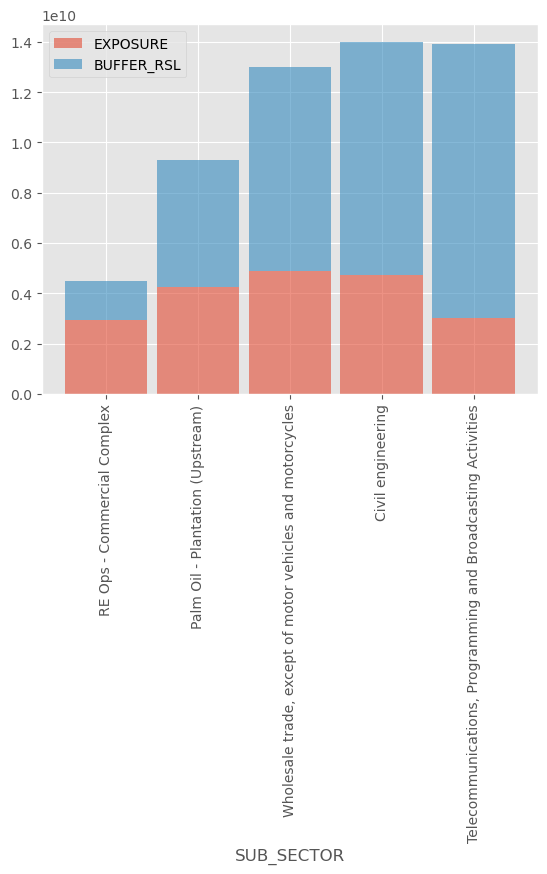

In [86]:
import seaborn as sns

import matplotlib.pyplot as plt

# set the plots to display within the Jupyter notebook
%matplotlib inline
plt.style.use('ggplot')

final[['SUB_SECTOR','EXPOSURE','BUFFER_RSL']].plot(x='SUB_SECTOR', y=['EXPOSURE','BUFFER_RSL'], kind='bar',stacked=True, alpha=0.6, width=0.9)

plt.show()

In [92]:
grouped_chk = filter9[(filter9.BROAD_SECTOR == 'Real Estate')][['BROAD_SECTOR','STAGE','EXPOSURE']].groupby(['BROAD_SECTOR','STAGE'],as_index=False).sum()
grouped_chk.head()


,BROAD_SECTOR,STAGE,EXPOSURE
0,Real Estate,1.00,5801986682.87
1,Real Estate,2.00,772306873.85
2,Real Estate,3.00,23704761.35


In [95]:
grouped_chk['%'] = 100 * grouped_chk['EXPOSURE'] / grouped_chk['EXPOSURE'].sum()
grouped_chk.head()

,BROAD_SECTOR,STAGE,EXPOSURE,%
0,Real Estate,1.00,5801986682.87,87.94
1,Real Estate,2.00,772306873.85,11.71
2,Real Estate,3.00,23704761.35,0.36


In [306]:
GIL = pd.read_sas(r'C:\Users\459354\Desktop\Python\shawn_python_import.sas7bdat', encoding='iso-8859-1')
GIL.loc[(GIL.POSITION_DT < '2021-12-31')]
GIL

,POSITION_DT,STAGE,EXPOSURE,GIL_SECTOR,GIL_RHB
0,2018-01-31,3.00,181472637.49,0.21,0.94
1,2018-02-28,3.00,178649937.79,0.21,0.96
2,2018-03-31,3.00,179757403.81,0.24,1.01
3,2018-04-30,3.00,180860515.08,0.24,1.15
4,2018-05-31,3.00,181989720.04,0.24,1.06
5,2018-06-30,3.00,184684386.21,0.25,1.10
6,2018-07-31,3.00,203148718.44,0.27,1.09
7,2018-08-31,3.00,180220074.96,0.24,1.27
8,2018-09-30,3.00,181294881.67,0.25,1.19
9,2018-10-31,3.00,182419525.59,0.25,1.15


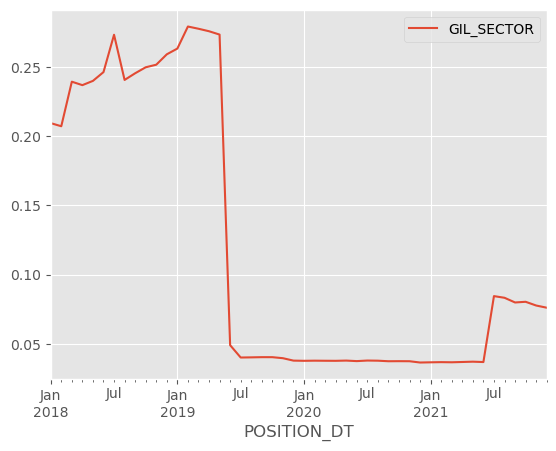

In [106]:
#timeseries 
GIL.plot(x='POSITION_DT', y='GIL_SECTOR')

plt.show()

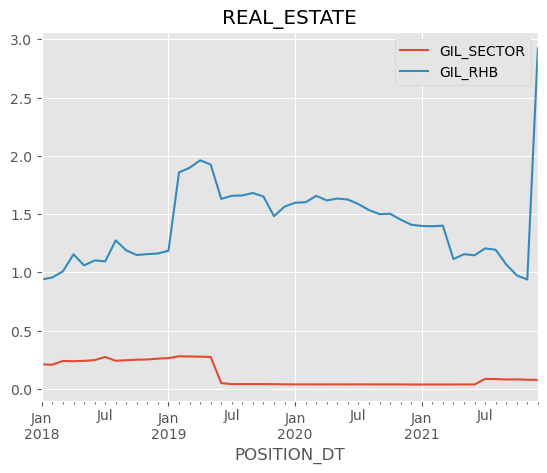

In [252]:

GIL.plot(x='POSITION_DT', y=['GIL_SECTOR','GIL_RHB'])
plt.title('REAL_ESTATE')
plt.show()

In [121]:

GIL['QUARTER'] = GIL.POSITION_DT.dt.quarter.astype(str)
GIL['YEAR'] =  GIL.POSITION_DT.dt.year.astype(str)   
GIL['POSITION'] = GIL.YEAR + '_' + GIL.QUARTER 
GIL_quarter = GIL[['POSITION','GIL_SECTOR']].groupby(['POSITION'],as_index=False).mean()


In [220]:
#import external variable in excel
variables = pd.read_excel(r'C:\Users\459354\Desktop\Python\Modelling.xlsx')

#left join

joined = pd.merge(variables,GIL_quarter, how ='left', on='POSITION')
joined

,POSITION,REAL_GDP,UMEMPLOYMENT_RATE,LABOUR_FORCE,EDF,GIL_SECTOR
0,2018_1,15386.87,3.30,15192.40,0.24,0.22
1,2018_2,15892.56,3.30,15278.30,0.24,0.24
2,2018_3,15840.28,3.40,15381.30,0.24,0.25
3,2018_4,16625.28,3.30,15449.90,0.24,0.25
4,2019_1,16548.25,3.30,15526.80,0.23,0.27
5,2019_2,17160.24,3.30,15598.80,0.19,0.20
6,2019_3,17069.40,3.30,15674.30,0.15,0.04
7,2019_4,17984.60,3.20,15766.70,0.14,0.04
8,2020_1,17128.67,3.50,15790.10,0.14,0.04
9,2020_2,12810.40,5.10,15675.50,0.16,0.04


In [289]:
for column in joined[['REAL_GDP','UMEMPLOYMENT_RATE','LABOUR_FORCE','EDF','GIL_SECTOR']].columns:
    joined[column] = ( joined[column] -
                            joined[column].mean()) /  joined[column].std()    
joined


,POSITION,REAL_GDP,UMEMPLOYMENT_RATE,LABOUR_FORCE,EDF,GIL_SECTOR
0,2018_1,0.11,-0.86,-1.81,1.11,1.01
1,2018_2,0.38,-0.86,-1.51,1.23,1.23
2,2018_3,0.35,-0.73,-1.14,1.14,1.36
3,2018_4,0.77,-0.86,-0.90,1.17,1.36
4,2019_1,0.73,-0.86,-0.62,0.87,1.56
5,2019_2,1.06,-0.86,-0.37,-0.18,0.81
6,2019_3,1.01,-0.86,-0.10,-1.32,-0.80
7,2019_4,1.50,-1.00,0.23,-1.48,-0.81
8,2020_1,1.04,-0.60,0.31,-1.62,-0.82
9,2020_2,-1.27,1.55,-0.09,-1.02,-0.82


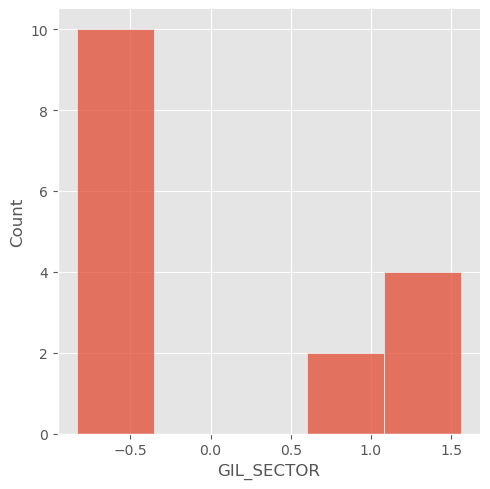

In [148]:
sns.displot(joined['GIL_SECTOR'])

In [258]:
from sklearn.metrics import r2_score 

R_square = r2_score(joined[['GIL_SECTOR']],joined[['REAL_GDP']] ) 
print('Coefficient of Determination', R_square) 


Coefficient of Determination -0.2287173415055801


In [149]:
joined.corr()

,REAL_GDP,UMEMPLOYMENT_RATE,LABOUR_FORCE,EDF,GIL_SECTOR
REAL_GDP,1.00,-0.89,-0.55,-0.14,0.39
UMEMPLOYMENT_RATE,-0.89,1.00,0.70,-0.14,-0.65
LABOUR_FORCE,-0.55,0.70,1.00,-0.46,-0.79
EDF,-0.14,-0.14,-0.46,1.00,0.75
GIL_SECTOR,0.39,-0.65,-0.79,0.75,1.00


In [280]:
X = joined[['REAL_GDP','UMEMPLOYMENT_RATE','LABOUR_FORCE','EDF']]
y = joined['GIL_SECTOR']




In [288]:
X.describe()

,REAL_GDP,UMEMPLOYMENT_RATE,LABOUR_FORCE,EDF
count,16.00,16.00,16.00,16.00
mean,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00
min,-1.70,-1.00,-1.81,-1.62
25%,-0.81,-0.86,-0.69,-0.62
50%,0.23,-0.66,0.07,-0.07
75%,0.83,1.04,0.83,0.93
max,1.50,1.55,1.54,1.23


In [281]:
from sklearn.model_selection import train_test_split


In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [283]:
from sklearn.linear_model import LinearRegression

In [284]:
lm = LinearRegression()

In [267]:
lm.fit(X_train,y_train)
r_squared = lm.score(X, y)

#view R-squared value
print(r_squared)


0.8098973425494826


In [237]:
print(lm.coef_)
print(lm.intercept_)

[-0.52162745 -0.75636091 -0.44840959  0.53632563]
0.10698492247934743


In [238]:
coef = pd.DataFrame(lm.coef_, X.columns, columns=['Coeff'])
coef

,Coeff
REAL_GDP,-0.52
UMEMPLOYMENT_RATE,-0.76
LABOUR_FORCE,-0.45
EDF,0.54


In [240]:
#Predictions
predictions = lm.predict(X_test)
predictions

array([ 2.11019695,  1.89872844,  0.27738905, -0.26969642, -0.22125761,
       -1.05229929])

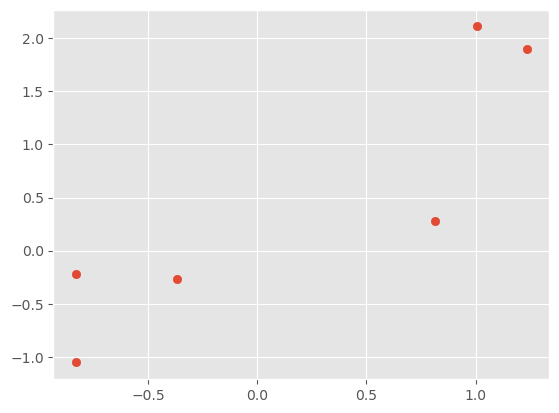

In [241]:
plt.scatter(y_test,predictions)

C:\Users\459354\Downloads\New folder\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GIL_SECTOR', ylabel='Density'>

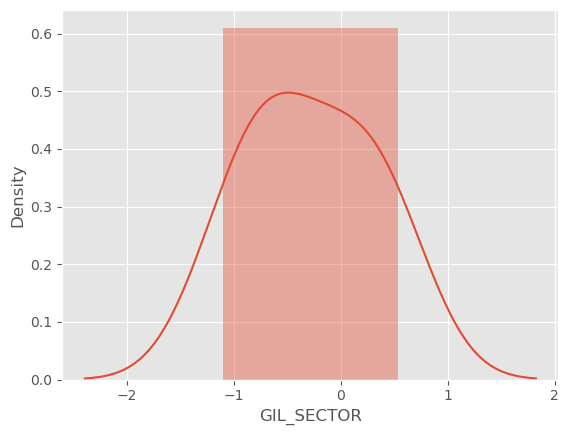

In [242]:
#residual looks normally distributed
sns.distplot((y_test-predictions))

In [244]:
from sklearn import metrics


LOWER MSE, the cloesr is forecast to actual

In [245]:
metrics.mean_absolute_error(y_test,predictions)

0.5390332187420404

In [246]:
metrics.mean_squared_error(y_test,predictions)

0.39561610573295186

In [278]:
X2 = joined[['REAL_GDP']]
y2= joined[['GIL_SECTOR']]

lm.fit(X2,y2)
r_squared_GDP = lm.score(X2, y2)
print(r_squared_GDP)

0.14871923482355498


In [270]:
X3 = joined[['UMEMPLOYMENT_RATE']]
y3= joined[['GIL_SECTOR']]

lm.fit(X3,y3)
r_squared_UE = lm.score(X3, y3)
print(r_squared_UE)

0.4185451602265343


In [293]:
X4 = joined[['LABOUR_FORCE']]
y4= joined[['GIL_SECTOR']]

lm.fit(X4,y4)
r_squared_LF = lm.score(X4, y4)
print(r_squared_LF)

0.6218727395866364


In [294]:
X5 = joined[['EDF']]
y5= joined[['GIL_SECTOR']]

lm.fit(X5,y5)
r_squared_EDF = lm.score(X5, y5)
print(r_squared_EDF)

0.5631201573169946


In [295]:
R2 = pd.DataFrame({'Variables': ['REAL_GDP','UMEMPLOYMENT_RATE','LABOUR_FORCE','EDF'],
                   'r_squared':  [r_squared_GDP,r_squared_UE,r_squared_LF,r_squared_EDF]
                   })
R2


,Variables,r_squared
0,REAL_GDP,0.15
1,UMEMPLOYMENT_RATE,0.42
2,LABOUR_FORCE,0.62
3,EDF,0.56
